In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
sns.set_context("paper", font_scale=2)

from pkasolver.constants import DEVICE
from pkasolver.data import calculate_nr_of_features
from pkasolver.ml import (
    dataset_to_dataloader,
    calc_testset_performace,
    calculate_performance_of_model_on_data,
)
from pkasolver.ml_architecture import GINPairV1, GINPairV2
BATCH_SIZE = 512
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

node_feat_list = [
    "element",
    "formal_charge",
    "hybridization",
    "total_num_Hs",
    "aromatic_tag",
    "total_valence",
    "total_degree",
    "is_in_ring",
    "reaction_center",
    "smarts",
]

edge_feat_list = ["bond_type", "is_conjugated", "rotatable"]
num_node_features = calculate_nr_of_features(node_feat_list)
num_edge_features = calculate_nr_of_features(edge_feat_list)

output_folder = "output"
# helper functions

def calc_rmse(pred, true):
    return np.sqrt(mean_squared_error(pred, true))

def confidence_calculation(sample_list):
    x = np.array(sample_list)
    m = x.mean()
    s = x.std()
    dof = len(x) - 1
    confidence = 0.95
    t_crit = np.abs(t.ppf((1 - confidence) / 2, dof))
    return (
        m,
        s * t_crit / np.sqrt(len(x)),
    )

def plot_results(x_col, y_col, y_error, name):
    # Define plot canvas
    g = sns.jointplot(
        x=x_col,
        y=y_col,
        xlim=(2, 12),
        ylim=(2, 12),
        kind="reg",
    )
    # Add fit_reg lines to plot
    sns.regplot(x=x_col, y=y_col, scatter=False, ax=g.ax_joint, truncate=False)
    # Add Diagonal line to Joint axes
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = np.array([max(x0, y0), min(x1, y1)])
    g.ax_joint.plot(lims, lims, "-r")
    # Add error band of pka ± 1
    g.ax_joint.fill_between(lims, lims - 1, lims + 1, color="r", alpha=0.2)
    g.ax_joint.errorbar(x_col, y_col, y_error, fmt="none", capsize=2, capthick=1, ecolor="red")
    g.set_axis_labels("exp", "pred")
    g.fig.suptitle(f"{name}")
    
    return g

# main function

def main(model_paths, test_path, name):
    print(f"load test dataset from: {test_path}")
    # read training set
    with open(test_path, "rb") as f:
        test_dateset = pickle.load(f)
    test_loader = dataset_to_dataloader(test_dateset, BATCH_SIZE, shuffle=False)

    if model_paths[0].__contains__("GINPairV1"):
        model_name, model_class = "GINPairV1", GINPairV1
    if model_paths[0].__contains__("GINPairV2"):
        model_name, model_class = "GINPairV2", GINPairV2

    mae, rmse, r2 = [], [], []
    for i, model_path in enumerate(model_paths):
        if name.__contains__("hp"):
            model = model_class(
                num_node_features, num_edge_features, hidden_channels=96
            )
        if name.__contains__("lp"):
            model = model_class(
                num_node_features, num_edge_features, hidden_channels=64
            )
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        model.to(device=DEVICE)
        MAE, RMSE, R2 = calc_testset_performace(model, test_loader)
        mae.append(MAE)
        rmse.append(RMSE)
        r2.append(R2)
        x, y = calculate_performance_of_model_on_data(model, test_loader)
        if i > 0:
            x_array = np.vstack((x_array, x))
            y_array = np.vstack((y_array, y))
        else:
            x_array = np.array(x)
            y_array = np.array(y)
    y_error = [ confidence_calculation(row)[1] for row in y_array.T ]
    x_array = x_array.mean(axis=0)
    y_array = y_array.mean(axis=0)
    mae_stats = confidence_calculation(mae)
    r2_stats = confidence_calculation(r2)
    rmse_stats = confidence_calculation(rmse)
    print(
        f"MAE: {confidence_calculation(mae)}, RMSE: {confidence_calculation(rmse)}, R2: {confidence_calculation(r2)}"
    )
    g = plot_results(x_array, y_array, y_error, name)
    g.ax_joint.text(
        1,
        0,
        f"""
        $r^2$ = {r2_stats[0]: .2f} $\pm$ {r2_stats[1]: .2f}
        $MAE$ = {mae_stats[0]: .2f} $\pm$ {mae_stats[1]: .2f}
        $RMSE$ = {rmse_stats[0]: .2f} $\pm$ {rmse_stats[1]: .2f}
        """,
        size="x-small",
        ha="right",
        va="bottom",
        transform=g.ax_joint.transAxes,
    )

Setting num threads to 1
Pytorch will use cuda


In [7]:
data_path = "/data/shared/projects/pkasolver-data-clean"
nov_test_path = f"{data_path}/05_novartis_testdata_pyg_data.pkl"
lit_test_path = f"{data_path}/05_AvLiLuMoVe_testdata_pyg_data.pkl"
nov_name = "GINPairV1_hp_novartis"
lit_name = "GINPairV1_hp_literature"
model_paths = [f"{data_path}/trained_models_v1/training_with_GINPairV1_v{i}_hp/reg_everything_best_model.pt" for i in range(50)]

load test dataset from: /data/shared/projects/pkasolver-data-clean/05_novartis_testdata_pyg_data.pkl
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False

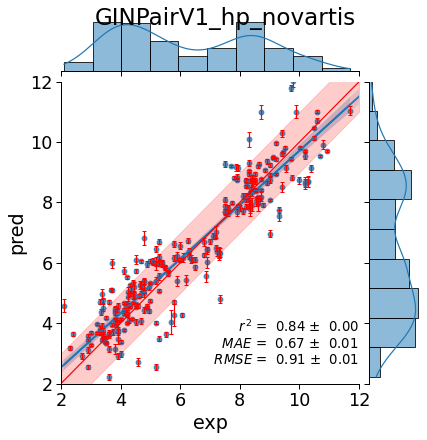

In [8]:
g = main(model_paths, nov_test_path, nov_name)
plt.savefig(f"{output_folder}/regression_{nov_name}.pdf", bbox_inches="tight")

load test dataset from: /data/shared/projects/pkasolver-data-clean/05_AvLiLuMoVe_testdata_pyg_data.pkl
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: False
Attention pooling: Fal

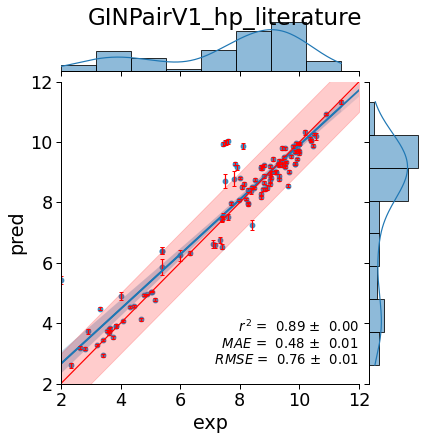

In [9]:
g = main(model_paths, lit_test_path, lit_name)
plt.savefig(f"{output_folder}/regression_{lit_name}.pdf", bbox_inches="tight")